### 9-bus test system
 Definition of the initial 9-bus test system (originally presented in Paul M. Anderson; A. A. Fouad, "Power System Control and Stability" , IEEE, 2003, pp.i-xiv, doi: 10.1109/9780470545577.fmatter.)

### First time this should be run in terminal: 
Install libraries (if  you use uv add dependencies are added to pyproject.toml automatically, if you use uv pip install you need to add manually)

In [1]:
# Create venv
uv venv
# Activate it
.\.venv\Scripts\activate
# Install packages in the venv
uv add highspy pyscipopt matplotlib pandas numpy cartopy
uv add jupyter
uv add pypsa

SyntaxError: invalid syntax (3868715102.py, line 2)

Comments:
I ran this in Visual Studio code and had to make two changes to default set up:
1) (rookie mistake): I had all the repos in a one-drive folder, which caused some issues, so i moved everything to a folder not in one-drive
2) Visual studio code has powershell as default terminal (at least in my setup) which was not permitted to activate the vevn. Just changing to command prompt solved this...

### Importing and defining models

In [2]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import highspy
import cartopy.crs as ccrs
import pandas as pd


In [146]:
#to plot the network this is called within the create_9_bus_network if plot=True
#using first snapshot values 
def plot_network(n):
    plt.figure(figsize=(12, 8))
    title="IEEE \n9-bus \nSystem"
    plt.title(title,loc='left')
    # Plot base network
    n.plot(
        bus_sizes=0.01,          
        line_widths=2,          
        bus_colors='red',       
        line_colors='blue',     
        margin=0.15,            
        geomap=False           
    )

    # Add bus labels with nominal voltage
    for bus in n.buses.index:
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        v_nom = n.buses.v_nom[bus]
        bus_type = n.buses.type[bus]
        plt.annotate(
            f"Bus {bus}\n{v_nom}kV\n{bus_type}",
            xy=(x, y),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    # Add generator labels with setpoints
    for gen in n.generators.index:
        bus = n.generators.bus[gen]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        # Access first snapshot of p_set time series
        p_set = n.generators_t.p_set[gen].iloc[0]
        p_nom = n.generators.p_nom[gen]
        plt.annotate(
            f"Gen {gen}\nP={p_set:.1f}MW\nPmax={p_nom:.1f}MW",
            xy=(x, y),
            xytext=(-75, -40),
            textcoords='offset points',
            color='magenta',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    # Add load labels with setpoints
    for load in n.loads.index:
        bus = n.loads.bus[load]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        p = n.loads_t.p_set.loc[n.snapshots[0],load]
        q = n.loads_t.q_set.loc[n.snapshots[0],load]
        plt.annotate(
            f"Load {load}\nP={p:.1f}MW\nQ={q:.1f}MVAr",
            xy=(x, y),
            xytext=(-60, 0),
            textcoords='offset points',
            color='brown',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )
    #add S_nom labels for branches
    for branch_type in ['Line','Transformer']:
        for branch in getattr(n,branch_type.lower()+'s').index:
            bus0=getattr(n,branch_type.lower()+'s').bus0[branch]
            bus1=getattr(n,branch_type.lower()+'s').bus1[branch]
            s_nom = getattr(n, branch_type.lower() + 's').s_nom[branch]
            r=getattr(n,branch_type.lower()+'s').r[branch]
            x_val=getattr(n,branch_type.lower()+'s').x[branch]
            x0, y0 = n.buses.x[bus0], n.buses.y[bus0]
            x1, y1 = n.buses.x[bus1], n.buses.y[bus1]
            mid_x, mid_y = ((x0 + x1) / 2)-0.25, ((y0 + y1)/2)-0.5
            plt.annotate(
                f"{s_nom:.1f}MVA \n r={r:.4f}\nx={x_val:.4f}",
                xy=(mid_x, mid_y),
                xytext=(0, 10),
                textcoords='offset points',
                color='green',
                bbox=dict(facecolor='white', alpha=0.7),
                fontsize=8,
                ha='center'
            )

    plt.grid(True)
    plt.axis('equal')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='red', label='Buses', 
               markersize=8, linestyle='None'),
        Line2D([0], [0], color='blue', label='Lines/Transformers', 
               linewidth=2),
        Line2D([0], [0], marker='s', color='magenta', label='Generators',
               markersize=8, linestyle='None'),
        Line2D([0], [0], marker='s', color='brown', label='Loads',
               markersize=8, linestyle='None')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.show()

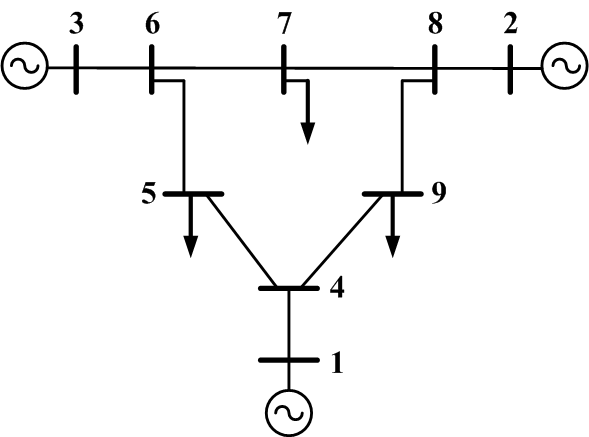

In [116]:
# In the official version generators are connected to bus 1, 2 and 3. 
# This is used as default, but can be changed by specifying bus numbers for each gen.

def create_9_bus_network(gen_bus1=1, gen_bus2=2, gen_bus3=3,steps=5,p_set_gen2=163,p_set_gen3=85,plot=False):
    network = pypsa.Network()
    # Define five snapshots
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    network.set_snapshots(snapshots)
    
    # Set base MVA
    network.sbase = 100.0
    
    # IEEE 9-bus layout coordinates
    bus_coordinates = {
        1: (0, 0),      # Generator 1 (slack)
        2: (4, 6),      # Generator 2
        3: (-4, 6),      # Generator 3
        4: (0, 2),     # Load bus
        5: (-2, 4),     # Load bus
        6: (-2, 6),    # Load bus
        7: (0, 6),      # Load bus
        8: (2, 6),      # Load bus
        9: (2, 4)      # Load bus
    }
    
    # Add buses with official IEEE data   
    for i in range(1, 10):
        bus_data = {
            "x": bus_coordinates[i][0],
            "y": bus_coordinates[i][1],
            "v_nom": 24, #if i in [1,2,3] else 24,
            "v_mag_pu_set": 1.04 if i == gen_bus1 else 1.025 if i in [gen_bus2,gen_bus3] else 1.0,
            "v_mag_pu_min": 0.9,
            "v_mag_pu_max": 1.1,
            "type": "Slack" if i == gen_bus1 else "PV" if i in [gen_bus2,gen_bus3] else "PQ"
            }
        network.add("Bus", f"Bus {i}", **bus_data)
        
        # Add loads with oscillating patterns
        if i in [5, 7, 9]:
            # Create base loads to generate varying load patterns
            base_p = {5: 90, 7: 100, 9: 125}[i]
            base_q = {5: 30, 7: 35, 9: 50}[i]
            variation = 0.3  # 10% variation
            #oscilation pattern based
            # on node number
            base_patterns = {5:np.array([1,0,1,0,-1]),
                        7:np.array([0,1,1,-1,-1]),
                        9: np.array([0,0,1,1,-1])}
            patterns_df = pd.DataFrame({bus: create_pattern(pattern, len(snapshots)) 
                                        for bus, pattern in base_patterns.items()},
                                       index=snapshots
                                       )
            # load is set as base plus/minus a variation of 
            load_p_set = base_p * (1 + variation * patterns_df[i])  # Oscillating pattern
            load_q_set = base_q * (1 + variation * patterns_df[i])  # Oscillating pattern
            
            network.add("Load", f"Load {i}", 
                bus=f"Bus {i}",
                p_set=pd.Series(load_p_set, index=snapshots),
                q_set=pd.Series(load_q_set, index=snapshots))
    
    ## Add Generators with official IEEE data
    gen_data = [
    {"bus": f"Bus {gen_bus1}","control":"Slack",
     "p_nom": 512*0.9,
     "p_min_pu": 10/(512*0.9),
     "p_set": pd.Series([0]*steps,index=snapshots),
     #"q_min_pu":-0.5,
     #"q_max_pu":0.5
     },
    {"bus": f"Bus {gen_bus2}", "control":"PV",
     "p_nom": 270*0.85, 
     "p_min_pu": 10/(270*0.85),
     "p_set": pd.Series([p_set_gen2]*steps, index=snapshots),
     #"q_min_pu":-0.5,
     #"q_max_pu":0.5
     },
    {"bus": f"Bus {gen_bus3}", "control":"PV",
     "p_nom": 125*0.85, 
     "p_min_pu": 10/(125*0.85), 
     "p_set": pd.Series([p_set_gen3]*steps, index=snapshots),
     #"q_min_pu":-0.5,
     #"q_max_pu":0.5
     }
    ]
    
    for i, gen in enumerate(gen_data):
        network.add("Generator", f"Gen {i+1}", **gen)
    
    ## Add Lines and Transformers with official IEEE data (https://ijiset.com/vol2/v2s4/IJISET_V2_I4_68.pdf) Note, bus numbers are not the same as in source
    branch_data = [
        # [from_bus, to_bus, r, x, b, s_nom, tap_ratio] r and x are in pu units
        [1, 4, 0.0000, 0.0576, 0.0000, 150, 1.0],#24/24],  # Transformer 1 (345/230 kV)
        [4, 5, 0.0100, 0.0920, 0.1580, 100, 1.0],      # Line
        [5, 6, 0.0390, 0.1700, 0.3580, 75, 1.0],      # Line
        [3, 6, 0.0000, 0.0586, 0.0000, 150, 1.0],#18/24],  # Transformer 2 (345/230 kV)
        [6, 7, 0.0119, 0.1008, 0.2090, 100, 1.0],      # Line
        [7, 8, 0.0085, 0.0720, 0.1490, 100, 1.0],      # Line
        [8, 2, 0.0000, 0.0625, 0.0000, 175, 1.0],#15,5/24],  # Transformer 3 (345/230 kV)
        [9, 8, 0.0320, 0.1610, 0.3060, 100, 1.0],      # Line
        [9, 4, 0.0100, 0.0850, 0.1760, 100, 1.0]       # Line
        ]
    
    """
    # original branch data for reference
    # [from_bus, to_bus, r, x, b, s_nom, tap_ratio] r and x are in pu units
    [1, 4, 0.0000, 0.0576, 0.0000, 250, 1.0],#24/24], # Transformer 1 (345/230 kV)
    [4, 5, 0.0100, 0.0920, 0.1580, 250, 1.0], # Line
    [5, 6, 0.0390, 0.1700, 0.3580, 150, 1.0], # Line
    [3, 6, 0.0000, 0.0586, 0.0000, 300, 1.0],#18/24], # Transformer 2 (345/230 kV)
    [6, 7, 0.0119, 0.1008, 0.2090, 150, 1.0], # Line
    [7, 8, 0.0085, 0.0720, 0.1490, 250, 1.0], # Line
    [8, 2, 0.0000, 0.0625, 0.0000, 250, 1.0],#15,5/24], # Transformer 3 (345/230 kV)
    [9, 8, 0.0320, 0.1610, 0.3060, 250, 1.0], # Line
    [9, 4, 0.0100, 0.0850, 0.1760, 250, 1.0] # Line
    
    """
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate, tap = branch
        if tap != 1.0:  # Tap not equal to 1 indicates a transformer
            network.add("Transformer", f"Transformer {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b/2,
                    s_nom=rate,
                    tap_ratio=tap)
        else:  # Tap equal to 1 indicates normal line (no transformer)
            network.add("Line", f"Line {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b/2,
                    s_nom=rate
                    )
    
    if plot:
        plot_network(network)
    return network

#Helper function for load pattern:
def create_pattern(base_pattern, num_steps):
    """
    Creates a pattern using numpy's repeat function
    Base pattern with 5 , modified to handle snapshots < 5 and snapshots > 5
    """
    pattern_length = len(base_pattern)
    repeats = np.ceil(num_steps / pattern_length).astype(int)
    extended_pattern = np.repeat(base_pattern, repeats)
    return extended_pattern[:num_steps]

In [ ]:

def model_results(n, print_results=False, plot_results=False):
    #n.lpf()
    n.pf(use_seed=True)
    # Create DataFrame with bus results for all snapshots
    bus_results = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )

    # Fill results for each snapshot
    for t in n.snapshots:
        for bus in n.buses.index:
            bus_results.loc[t, (bus, 'P (MW)')] = n.buses_t.p.loc[t, bus]
            bus_results.loc[t, (bus, 'Q (MVAr)')] = n.buses_t.q.loc[t, bus]
            bus_results.loc[t, (bus, 'V (pu)')] = n.buses_t.v_mag_pu.loc[t, bus]
            bus_results.loc[t, (bus, 'Angle (deg)')] = n.buses_t.v_ang.loc[t, bus]
    # Create DataFrame for line results
    line_results = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.lines.index,
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)']
        ])
    )

    # Fill line results
    for t in n.snapshots:
        for line in n.lines.index:
            line_results.loc[t, (line, 'P0 (MW)')] = n.lines_t.p0.loc[t, line]
            line_results.loc[t, (line, 'P1 (MW)')] = n.lines_t.p1.loc[t, line]
            line_results.loc[t, (line, 'Q0 (MVAr)')] = n.lines_t.q0.loc[t, line]
            line_results.loc[t, (line, 'Q1 (MVAr)')] = n.lines_t.q1.loc[t, line]
    
    if print_results:
        print("\nBus Results:") 
        print(bus_results)
        print("\nLine Results:")
        print(line_results)
        #for s in results_df.index:
        #    print(results_df.loc[s])
    if plot_results:
        plot_network_results(n, bus_results)
        plot_line_results(n, line_results)

    return bus_results, line_results

def plot_network_results(network, results_df):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    for bus in network.buses.index:
        # Determine bus type for legend
        if bus in network.loads.bus.values:
            bus_type = f"{bus} (Load)"
        elif bus in network.generators.bus.values:
            gen_idx = network.generators[network.generators.bus == bus].index[0]
            if network.generators.loc[gen_idx, 'control'] == 'Slack':
                bus_type = f"{bus} (Gen-Slack)"
            else:
                bus_type = f"{bus} (Gen-PV)"
        else:
            bus_type = bus
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line flow results with one subplot per line, showing P0/P1 and Q0/Q1
    """
    n_lines = len(network.lines)
    fig, axs = plt.subplots(n_lines, 2, figsize=(12, 2*n_lines), sharex=True)
    
    # Get data for each line
    for i, line in enumerate(network.lines.index):
        # Get from/to bus names for title
        from_bus = network.lines.loc[line, 'bus0']
        to_bus = network.lines.loc[line, 'bus1']
        line_name = f"{line} ({from_bus}->{to_bus})"
        
        # Get S_nom for reference line
        s_nom = network.lines.loc[line, 's_nom']
        
        # Active Power (P) - Left subplot
        axs[i, 0].plot(results_df.index, results_df[line]['P0 (MW)'], marker='o', 
                label=f"P-in (from {from_bus})")
        axs[i, 0].plot(results_df.index, -results_df[line]['P1 (MW)'], marker='s', 
                label=f"P-out (to {to_bus})")
        # Add S_nom reference lines
        axs[i, 0].axhline(y=s_nom, color='r', linestyle='--', 
                          label=f"S_nom = {s_nom} MVA")
        axs[i, 0].axhline(y=-s_nom, color='r', linestyle='--', 
                          label=f"S_nom = {-s_nom} MVA")
        axs[i, 0].set_ylabel('P (MW)')
        axs[i, 0].set_title(f"Active Power Flow - {line_name}")
        axs[i, 0].legend()
        axs[i, 0].grid(True)
        
        # Reactive Power (Q) - Right subplot
        axs[i, 1].plot(results_df.index, results_df[line]['Q0 (MVAr)'], marker='o', 
                label=f"Q-in (from {from_bus})")
        axs[i, 1].plot(results_df.index, -results_df[line]['Q1 (MVAr)'], marker='s', 
                label=f"Q-out(to {to_bus})")
        axs[i, 1].set_ylabel('Q (MVAr)')
        axs[i, 1].set_title(f"Reactive Power Flow - {line_name}")
        axs[i, 1].legend()
        axs[i, 1].grid(True)
        
    # Add common x-axis label
    fig.text(0.5, 0.04, 'Time', ha='center')
    
    plt.tight_layout()
    plt.show()

### Running power flow simulations


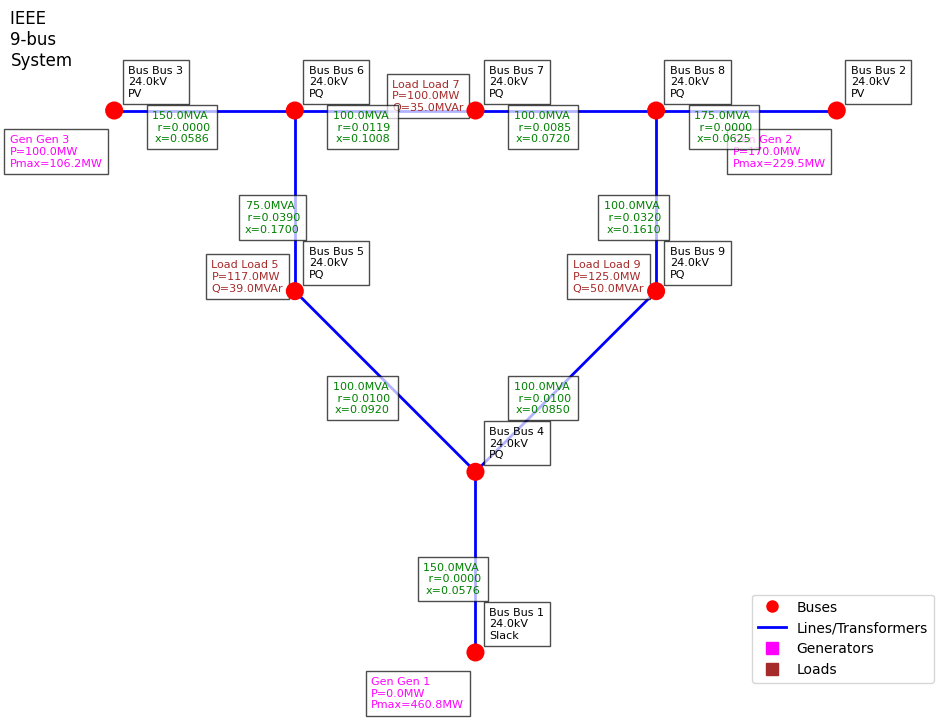

In [147]:
n = create_9_bus_network(steps=15,p_set_gen2=170,p_set_gen3=100,plot=True) # create the network with input parameters

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00', '2025-01-01 05:00:00',
               '2025-01-01 06:00:00', '2025-01-01 07:00:00',
               '2025-01-01 08:00:00', '2025-01-01 09:00:00',
               '2025-01-01 10:00:00', '2025-01-01 11:00:00',
               '2025-01-01 12:00:00', '2025-01-01 13:00:00',
               '2025-01-01 14:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.017507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.020839 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.012021 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.020868 second

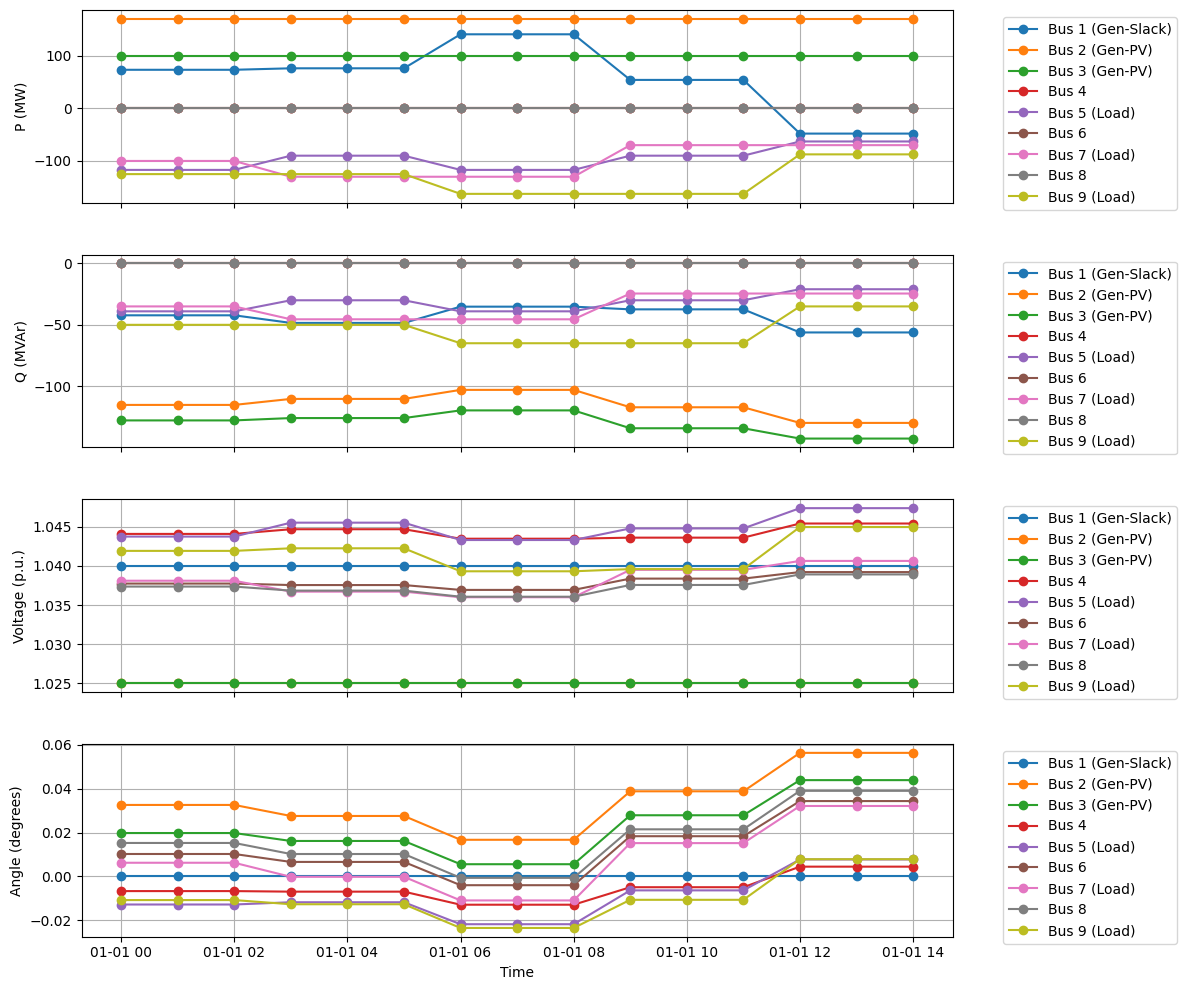

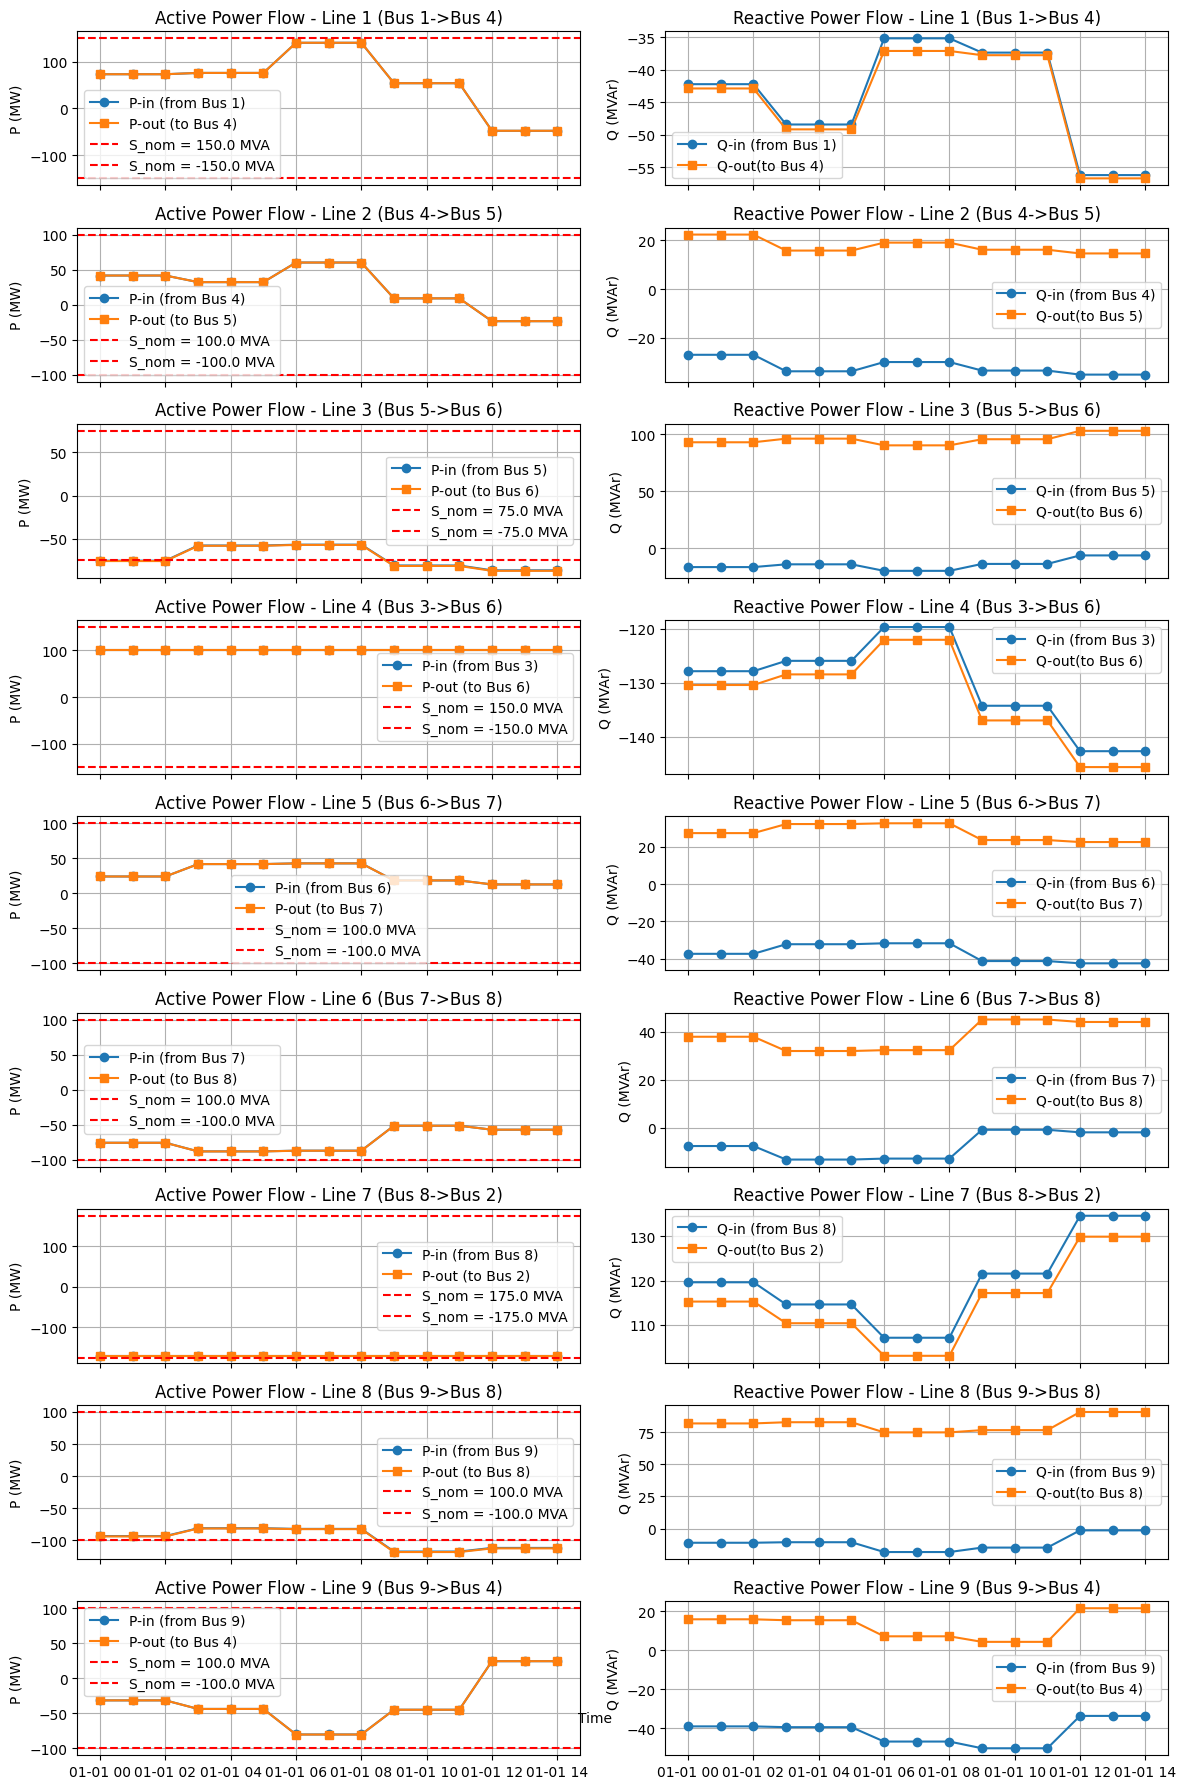

In [148]:
#n = create_9_bus_network(steps=15,p_set_gen2=170,p_set_gen3=100,plot=True) # create the network with input parameters
bus_results,line_results=model_results(n,print_results=False, plot_results=True) # run the power flow and store results in dfs. Print if print_results = True, plot results if Plot=True

count    9.000000
mean    -0.008708
std      0.808251
min     -1.169829
25%     -0.531145
50%      0.244035
75%      0.402359
max      1.421250
dtype: float64